# HR Analytics: Data Preprocessing

Notebook này thực hiện preprocessing cho dataset HR Analytics.

## Mục tiêu:
1. Xử lý missing values
2. Encode categorical variables
3. Feature scaling (Normalization/Standardization)
4. Feature engineering
5. Handle outliers
6. Lưu processed data

In [1]:
# Cell 1: Import và load data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('../src')

from data_processing import DataProcessor
from visualization import DataVisualizer

processor = DataProcessor()
visualizer = DataVisualizer()

data, headers = processor.load_csv('../data/raw/aug_train.csv')
print(f"Original shape: {data.shape}")

Original shape: (19158, 14)


In [2]:
# Cell 2: Handle missing values
print("\n=== HANDLING MISSING VALUES ===\n")

# Numerical features
numerical_features = ['city_development_index', 'training_hours']
categorical_features = ['gender', 'relevant_experience', 'enrolled_university',
                       'education_level', 'major_discipline', 'experience',
                       'company_size', 'company_type', 'last_new_job']
ordinal_features = ['relevent_experience', 'education_level', 'experience', 
                        'company_size', 'last_new_job']
# 'company_type' nên là nominal vì không có thứ tự rõ ràng (Pvt Ltd vs NGO)
nominal_features = ['gender', 'major_discipline', 'enrolled_university', 'company_type']

# B. Lấy danh sách tên cột features (bỏ target và enrollee_id)
feature_names = [h for h in headers if h not in ['enrollee_id', 'target']]

for feat in numerical_features:
    col_idx = headers.index(feat)
    col = data[:, col_idx].copy()
    # fill_missing_numerical returns (filled_array, statistic), so unpack it
    filled_array, _ = processor.fill_missing_numerical(col, strategy='median')
    data[:, col_idx] = filled_array.astype(str)
    print(f"Filled {feat} with median")

for feat in categorical_features:
    if feat in headers:
        col_idx = headers.index(feat)
        col = data[:, col_idx].copy()
        # fill_missing_categorical returns (filled_array, statistic), so unpack it
        filled_array, _ = processor.fill_missing_categorical(col, strategy='mode')
        data[:, col_idx] = filled_array
        print(f"Filled {feat} with mode")

# Verify
missing_mask, missing_count = processor.check_missing_values(data)
print(f"\nRemaining missing values: {np.sum(missing_count)}")


=== HANDLING MISSING VALUES ===

Filled city_development_index with median
Filled training_hours with median
Filled gender with mode
Filled enrolled_university with mode
Filled education_level with mode
Filled major_discipline with mode
Filled experience with mode
Filled company_size with mode
Filled company_type with mode
Filled last_new_job with mode

Remaining missing values: 0


In [3]:
# Cell 3: Feature encoding
print("\n=== FEATURE ENCODING ===\n")

X_processed = []
feature_names_processed = []
encoding_maps = {}

# Get target
target_idx = headers.index('target')
target = data[:, target_idx].astype(float)

# Process numerical features
for feat in numerical_features:
    col_idx = headers.index(feat)
    col = data[:, col_idx].astype(float)
    
    X_processed.append(col)
    feature_names_processed.append(feat)
    print(f"Processed {feat} as numerical")

# Process categorical features
for feat in categorical_features:
    if feat in headers:
        col_idx = headers.index(feat)
        col = data[:, col_idx]
        
        encoded, mapping = processor.encode_categorical(col)
        X_processed.append(encoded.astype(float))
        feature_names_processed.append(feat)
        encoding_maps[feat] = mapping
        print(f"Encoded {feat} ({len(mapping)} categories)")

X = np.column_stack(X_processed)
print(f"\nProcessed shape: {X.shape}")
feature_names = feature_names_processed.copy()


=== FEATURE ENCODING ===

Processed city_development_index as numerical
Processed training_hours as numerical
Encoded gender (3 categories)
Encoded enrolled_university (3 categories)
Encoded education_level (5 categories)
Encoded major_discipline (6 categories)
Encoded experience (22 categories)
Encoded company_size (8 categories)
Encoded company_type (6 categories)
Encoded last_new_job (6 categories)

Processed shape: (19158, 10)


In [4]:
# Inspect gender column
col_idx = headers.index('gender')
gender_col = data[:, col_idx]
print("First 20 gender values:")
print(gender_col[:20])
unique_vals, counts = np.unique(gender_col, return_counts=True)
print("\nDistribution (including missing tokens if any):")
for v, c in zip(unique_vals, counts):
    pct = c / len(gender_col) * 100
    print(f"{v if v != '' else '<EMPTY>'}: {c} ({pct:.2f}%)")

First 20 gender values:
['Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male'
 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Female']

Distribution (including missing tokens if any):
Female: 1238 (6.46%)
Male: 17729 (92.54%)
Other: 191 (1.00%)


In [5]:
# Cell 4: Feature scaling
print("\n=== FEATURE SCALING ===\n")

# Ensure float dtype for scaled array
X_scaled = np.zeros_like(X, dtype=float)

# Local implementations of z-score standardization and min-max normalization
for i, feat in enumerate(feature_names_processed):
    col = X[:, i].astype(float)
    if feat in numerical_features:
        mean = np.mean(col)
        std = np.std(col)
        if np.isclose(std, 0.0):
            X_scaled[:, i] = 0.0
        else:
            X_scaled[:, i] = (col - mean) / std
        print(f"Standardized {feat} (z-score)")
    else:
        minv = np.min(col)
        maxv = np.max(col)
        if np.isclose(maxv - minv, 0.0):
            X_scaled[:, i] = 0.0
        else:
            X_scaled[:, i] = (col - minv) / (maxv - minv)
        print(f"Normalized {feat} (min-max)")

# Verify scaling
print("\nScaled data statistics:")
print(f"  Mean: {np.mean(X_scaled, axis=0)[:3]}")
print(f"  Std: {np.std(X_scaled, axis=0)[:3]}")
print(f"  Min: {np.min(X_scaled, axis=0)[:3]}")
print(f"  Max: {np.max(X_scaled, axis=0)[:3]}")


=== FEATURE SCALING ===

Standardized city_development_index (z-score)
Standardized training_hours (z-score)
Normalized gender (min-max)
Normalized enrolled_university (min-max)
Normalized education_level (min-max)
Normalized major_discipline (min-max)
Normalized experience (min-max)
Normalized company_size (min-max)
Normalized company_type (min-max)
Normalized last_new_job (min-max)

Scaled data statistics:
  Mean: [-3.14185061e-16 -3.36926436e-17  4.72674601e-01]
  Std: [1.         1.         0.13379419]
  Min: [-3.08732585 -1.07176531  0.        ]
  Max: [0.97400635 4.50627869 1.        ]



=== OUTLIER DETECTION ===

city_development_index:
  IQR method: 17 outliers (0.09%)
  Z-score method: 17 outliers (0.09%)


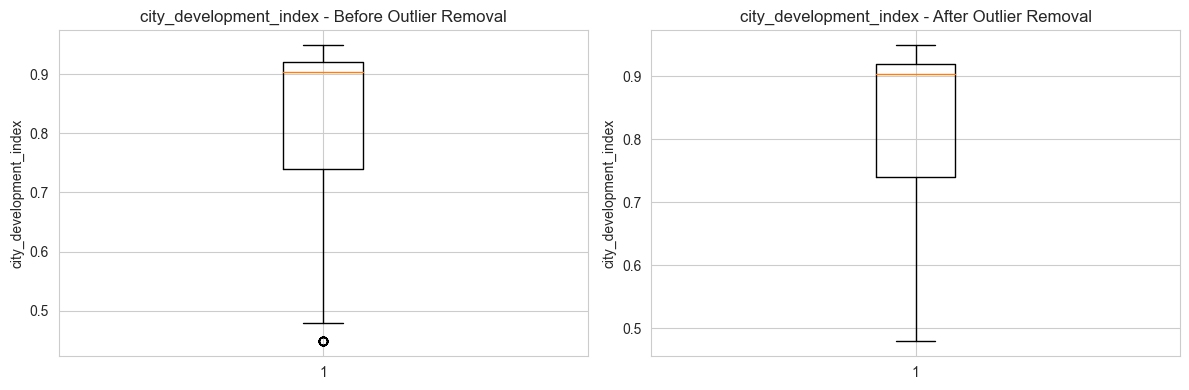

training_hours:
  IQR method: 984 outliers (5.14%)
  Z-score method: 450 outliers (2.35%)


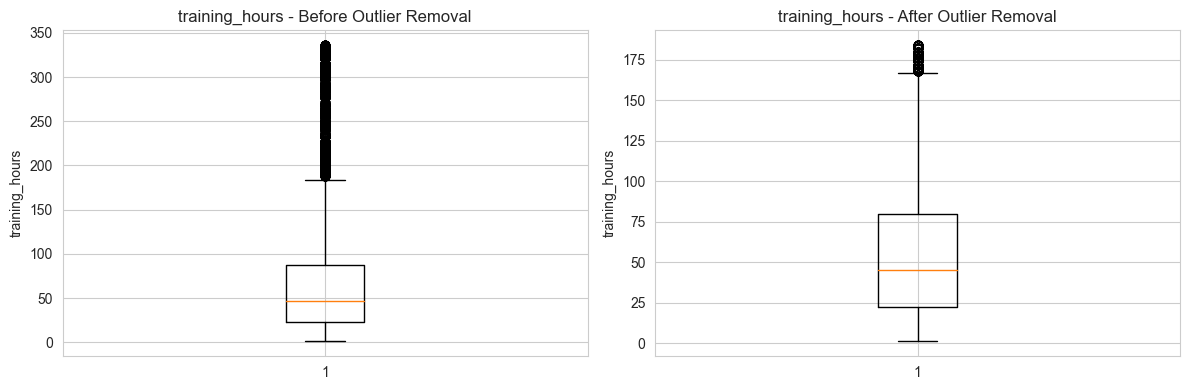

In [6]:
# Cell 5: Outlier detection
print("\n=== OUTLIER DETECTION ===\n")

for i, feat in enumerate(feature_names_processed):
    if feat in numerical_features:
        col = X[:, i].astype(float)
        
        # IQR method
        outliers_iqr = processor.detect_outliers_iqr(col, multiplier=1.5)
        # detector returns a dict: use the provided counts/mask
        n_outliers_iqr = int(outliers_iqr.get('n_outliers', np.sum(outliers_iqr.get('outlier_mask', np.zeros(len(col), dtype=bool)))))
        outlier_mask_iqr = outliers_iqr.get('outlier_mask', None)
        
        # Z-score method
        outliers_z = processor.detect_outliers_zscore(col, threshold=3)
        n_outliers_z = int(outliers_z.get('n_outliers', np.sum(outliers_z.get('outlier_mask', np.zeros(len(col), dtype=bool)))))
        outlier_mask_z = outliers_z.get('outlier_mask', None)
        
        print(f"{feat}:")
        print(f"  IQR method: {n_outliers_iqr} outliers ({n_outliers_iqr/len(col)*100:.2f}%)")
        print(f"  Z-score method: {n_outliers_z} outliers ({n_outliers_z/len(col)*100:.2f}%)")
        
        # Visualize
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.boxplot(col)
        ax1.set_title(f'{feat} - Before Outlier Removal')
        ax1.set_ylabel(feat)
        
        # Remove outliers using IQR (if reasonable)
        if n_outliers_iqr / len(col) < 0.1 and outlier_mask_iqr is not None:  # Chỉ remove nếu < 10%
            col_no_outliers = col[~outlier_mask_iqr]
            ax2.boxplot(col_no_outliers)
            ax2.set_title(f'{feat} - After Outlier Removal')
            ax2.set_ylabel(feat)
        else:
            # If we don't remove outliers, show an empty/placeholder plot
            ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

In [7]:
# Cell 6: Feature engineering
print("\n=== FEATURE ENGINEERING ===\n")

# Example: Create interaction features
if 'city_development_index' in feature_names_processed and 'training_hours' in feature_names_processed:
    cdi_idx = feature_names_processed.index('city_development_index')
    th_idx = feature_names_processed.index('training_hours')
    
    # Create interaction feature directly (element-wise product of the two scaled cols)
    interaction = (X_scaled[:, cdi_idx].astype(float) * X_scaled[:, th_idx].astype(float)).ravel()
    
    # Add to features
    X_scaled = np.column_stack([X_scaled, interaction])
    feature_names_processed.append('cdi_x_training_hours')
    
    print("Created interaction feature: cdi_x_training_hours")

print(f"\nFinal shape after feature engineering: {X_scaled.shape}")



=== FEATURE ENGINEERING ===

Created interaction feature: cdi_x_training_hours

Final shape after feature engineering: (19158, 11)


In [ ]:
# Cell 2: Data Pipeline (Exact Match with main.py)

# 2. Định nghĩa Features (COPY CHÍNH XÁC TỪ main.py)
# Trong main.py, 'city' KHÔNG nằm trong các list này, nếu notebook tự thêm vào sẽ gây sai lệch
ordinal_features = ['relevent_experience', 'education_level', 'experience', 
                    'company_size', 'last_new_job']
# Lưu ý: main.py không có 'city' trong nominal_features ở đoạn code mẫu
nominal_features = ['gender', 'major_discipline', 'enrolled_university', 'company_type']
numerical_features = ['city_development_index', 'training_hours']

# Lấy tên tất cả các cột feature
feature_names = [h for h in headers if h not in ['enrollee_id', 'target']]

# Lấy X, y thô
X_raw = processor.get_columns_by_names(data, headers, feature_names)
# Lấy target
target_idx = headers.index('target')
y_raw = data[:, target_idx].astype(float)

# 3. Split Data (Giống main.py)
print("-> Splitting Data (80/20, random_state=42)...")
X_train_raw, X_test_raw, y_train, y_test = processor.train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

# 4. Preprocessing (Fit Train -> Transform Test)
print("-> Processing Features (Using DataProcessor logic)...")

# Fit & Transform Train
X_train, _ = processor.fit_transform_features(
    X_train_raw,         
    feature_names,       
    y_train,             
    ordinal_features,
    nominal_features,
    numerical_features
)

# Transform Test (Dùng tham số đã học từ Train)
X_test = processor.transform_features(
    X_test_raw,          
    feature_names,       
    ordinal_features,
    nominal_features,
    numerical_features
)

print(f"Data Ready. Shapes: X_train={X_train.shape}, X_test={X_test.shape}")
# Kiểm tra số lượng features. Nếu main.py ra 11 features, ở đây cũng phải là 11.
print(f"Number of features: {X_train.shape[1]}")

-> Splitting Data (80/20, random_state=42)...
-> Processing Features (Using DataProcessor logic)...
  [Train] Processing Ordinal Features...
  [Train] Processing Nominal Features...
  [Train] Processing Numerical Features...
✅ Data Ready. Shapes: X_train=(15327, 25), X_test=(3831, 25)
Number of features: 25


In [ ]:
try:
    test_path = '../data/raw/aug_test.csv'
    test_data, test_headers = processor.load_csv(test_path)
    
    # Lấy ID
    id_idx = test_headers.index('enrollee_id')
    submission_ids = test_data[:, id_idx]
    
    # Lấy X raw
    X_sub_raw = processor.get_columns_by_names(test_data, test_headers, feature_names)
    
    # Transform bằng processor đã fit ở trên
    print("Transforming submission data...")
    X_submission = processor.transform_features(
        X_sub_raw, feature_names,
        ordinal_features, nominal_features, numerical_features
    )
    print(f"Submission Shape: {X_submission.shape}")
    
except Exception as e:
    print(f"Error processing submission data: {e}")

# Cell 4: Save Processed Data
# Lưu tất cả ra file .npy để modeling.ipynb sử dụng
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

print("Saving data to disk...")
np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)
np.save(os.path.join(output_dir, 'X_submission.npy'), X_submission)
np.save(os.path.join(output_dir, 'submission_ids.npy'), submission_ids)

# Lưu tên features để vẽ biểu đồ
with open(os.path.join(output_dir, 'feature_names.txt'), 'w') as f:
    for item in feature_names:
        f.write(f"{item}\n")

print("All data saved successfully!")

Transforming submission data...
Submission Shape: (2129, 25)
Saving data to disk...
✅ All data saved successfully!
